In [4]:
import pandas as pd
from google.colab import drive
import nltk
import random
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
drive.mount('/content/drive')
nltk.download('wordnet')

Mounted at /content/drive


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data_set=pd.read_csv("/content/drive/MyDrive/Assignment2/rt_reviews.csv",encoding='latin-1')
data_set.head(5)

,Freshness,Review
0,fresh,"Manakamana doesn't answer any questions, yet ..."
1,fresh,Wilfully offensive and powered by a chest-thu...
2,rotten,It would be difficult to imagine material mor...
3,rotten,Despite the gusto its star brings to the role...
4,rotten,If there was a good idea at the core of this ...


In [7]:
data_set["Freshness"].isnull().sum()

0

In [8]:
data_set["Review"].isnull().sum()

0

In [9]:
import random
data_set.sort_values(by = 'Review', ascending=True, inplace=True)
print(data_set.shape)
train_split_index = int(0.7 * len(data_set))
dev_split_index = int(0.9 * len(data_set))
train_data = data_set[:train_split_index]
dev_data = data_set[train_split_index:dev_split_index]
test_data = data_set[dev_split_index:]

print(train_data.shape)
print(dev_data.shape)
print(test_data.shape)



(480000, 2)
(336000, 2)
(96000, 2)
(48000, 2)


In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

{"that'll", 'an', 'any', 'weren', 'himself', 'have', 'if', 'to', 'with', 'where', 'hers', 'who', 'about', 'here', 'by', "couldn't", 'don', 'myself', 'into', 'shan', 'down', "isn't", 'doesn', 'very', 'against', 'themselves', 'and', 'our', 'above', 'was', 'as', 'whom', "weren't", 'aren', "mustn't", 'you', 'are', 'it', 'were', 'isn', 'some', 'off', 'which', 'those', 'we', 'nor', 'having', 'y', 'such', "haven't", 'after', 'most', 'no', 'not', 'm', 'of', 'over', 'own', 'can', 'needn', 'ours', 'his', 'in', 'out', 'only', 'didn', 'up', 'the', "you're", 'hasn', 'all', 'should', 'before', 'shouldn', "wouldn't", 'for', "hasn't", "hadn't", 'their', 'has', 'mustn', 'from', 'just', "didn't", 'mightn', "it's", 'because', 'that', "you've", 'll', 'yours', 'at', 'wouldn', 'a', 'is', 'does', 'had', 'what', "wasn't", 'itself', 'won', 'these', 'when', "won't", 'me', "shouldn't", 'am', 'haven', 'through', "you'll", 'herself', 'its', 'then', 'now', 'between', 'but', 'or', "doesn't", 'while', 'so', 'yourself

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
import re
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()
def preprocess_and_create_vocabulary(sentences):
  word_dict = {}
  final_word_dict={}

  for i in range(len(sentences)):
    sentences[i] = re.sub(r"\W", " ", sentences[i]) 
    sentences[i] = re.sub(r"\d", " ", sentences[i])
    sentences[i] = sentences[i].lower()
    for word in sentences[i].split():
      word = ''.join(lemmatizer.lemmatize(word))
      
      if word not in stop_words:
        word_dict[word] = word_dict.get(word,0) + 1
  for k,v in word_dict.items():
    if v > 5:
      final_word_dict[k] = v
  return final_word_dict

train_sentences =  train_data["Review"].tolist()
final_word_dict=preprocess_and_create_vocabulary(train_sentences)


In [12]:
len(final_word_dict)

28874

In [13]:
def calculate_prob_word_occurence(word_dict):
  prob_word_dict={}
  for word,count in word_dict.items():
    prob = count/sum(word_dict.values())
    prob_word_dict[word] = prob
  return prob_word_dict

In [14]:

def find_prior_probability(word_dict,data):
  total_rows = len(data)
  target_values = list(data["Freshness"].unique())
  target_types_dict={}
  prior_prob_dict={}
  for target in target_values:
    count = (data['Freshness'] == target).sum()
    target_types_dict[target] = count
    prior_prob_dict[target] = count/total_rows
  return target_types_dict,prior_prob_dict

target_types_dict,prior_prob_dict = find_prior_probability(final_word_dict,train_data)
for k,v in prior_prob_dict.items():
  print(f"Prior Probability of {k} is {v}")


Prior Probability of rotten is 0.48604761904761906
Prior Probability of fresh is 0.5139523809523809


In [15]:
calculate_prob_word_occurence

<function __main__.calculate_prob_word_occurence(word_dict)>

In [32]:
prob_word_dict = calculate_prob_word_occurence(final_word_dict)


In [17]:
def find_cond_prob_word(target_types_dict,data,):
  cond_prob_dict={}
  for target_type in target_types_dict.keys():
    sentences_with_class =  data.loc[data['Freshness'] == target_type, 'Review'].tolist()
    final_word_dict = preprocess_and_create_vocabulary(sentences_with_class)
    for word,count in final_word_dict.items():
      total_word_count = sum(final_word_dict.values())
      cond_prob_dict[target_type+" "+word] = count/total_word_count
  return cond_prob_dict


cond_prob_dict=find_cond_prob_word(target_types_dict,train_data)

In [33]:
def get_top_10words(target_types_dict,cond_prob_dict):
  print("The Top 10 words for each class are:")

  for target in target_types_dict.keys():
    sorted_dict = dict(sorted(cond_prob_dict.items(), key=lambda x: x[1], reverse=True))
    print(f"For Class {target} :" )
    top_10_values = {key.split()[1]:cond_prob_dict.get(key) for key in cond_prob_dict if key.startswith(target)}
    sorted_result = sorted(top_10_values.items(), key=lambda x: x[1], reverse=True)[:10]

    print(sorted_result)
    
get_top_10words(target_types_dict,cond_prob_dict)

The Top 10 words for each class are:
For Class rotten :
[('movie', 0.012701920158038206), ('film', 0.01204805043580186), ('like', 0.0077416531449695436), ('one', 0.0068648616164091), ('ha', 0.005600781972714165), ('much', 0.004654134762909304), ('make', 0.004548323951612613), ('story', 0.004285337857515984), ('character', 0.004055738669896464), ('even', 0.004051629512176204)]
For Class fresh :
[('film', 0.015051452111728883), ('movie', 0.010214760931077151), ('one', 0.007847169581667568), ('ha', 0.005737109010240608), ('like', 0.005269982015140742), ('story', 0.0049593472628660824), ('make', 0.004412329332990585), ('performance', 0.004014284499137883), ('time', 0.003974339031750067), ('good', 0.0037121087870159372)]


In [19]:
dev_row = dev_data.sample(n=1)
type(dev_row)
dev_row

,Freshness,Review
340960,fresh,This is a fine film that is as much about the...


In [28]:
def NaiveBayes(alpha,test_data):
  for target_type in target_types_dict.keys():
    cond_prob = {key.split()[1]:cond_prob_dict.get(key) for key in cond_prob_dict if key.startswith(target_type)}
  
  den = 1
  predction_prob={}
  num = 1
  k = 1  #no of features is 1 in this case
 
  for target_type in target_types_dict.keys():
    prior_prob_class = prior_prob_dict[target_type]
    if alpha is None:
      for word in test_data:
        if word not in stop_words:
          if word in cond_prob.keys():
            num = num * cond_prob[word]
            den = den * prob_word_dict[word]
      final_prob = (num * prior_prob_class)/den
    else:
      for word in test_data:
        if word not in stop_words:
          if word in cond_prob.keys():
            num = num * cond_prob[word] 
            den = den * prob_word_dict[word]
      final_prob = (num + alpha)/den + alpha * k
    predction_prob[target_type] = final_prob

  max_class, max_acc = max(predction_prob.items(), key=lambda x: x[1])

  return max_class,max_acc




    

In [21]:
import numpy as np
correct_predictions=0
labels = dev_data["Freshness"]
class_labels = np.array(labels.values[:10])
# print(class_labels[:10])
for i, row in dev_data.iloc[:10].iterrows():
  i=1
  class_label, acc =  NaiveBayes(None,row)
  if class_label == class_labels[i]:
    correct_predictions +=1
  i+=1
prediction_accuracy = correct_predictions/10


print("Prediction accuracy for 10 rows in developement dataset  : ",prediction_accuracy)



Prediction accuracy for 10 rows in developement dataset  :  0.7


Without Laplace Smoothing

In [22]:
test_row = dev_data.sample(n=1)

In [23]:

class_label, prob =NaiveBayes(None,test_row)
print(f"Predicted label of {test_row.iloc[0,1]} is : {class_label} with probability {round(prob,2)}")

Predicted label of  The question before us is: When exactly did Jonathan Demme lose his sense of humor? is : fresh with probability 0.51


With alpha  = 0.4

In [29]:
class_label, prob =NaiveBayes(0.4,test_row)
print(f"Predicted label of {test_row.iloc[0,1]} is : {class_label} with probability {round(prob,2)}")

Predicted label of  The question before us is: When exactly did Jonathan Demme lose his sense of humor? is : rotten with probability 0.56


With alpha = 0.45

In [30]:
class_label, prob =NaiveBayes(0.45,test_row)
print(f"Predicted label of {test_row.iloc[0,1]} is : {class_label} with probability {round(prob,2)}")

Predicted label of  The question before us is: When exactly did Jonathan Demme lose his sense of humor? is : rotten with probability 0.65


With alpha = 0.55

In [31]:
class_label, prob =NaiveBayes(0.55,test_row)
print(f"Predicted label of {test_row.iloc[0,1]} is : {class_label} with probability {round(prob,2)}")

Predicted label of  The question before us is: When exactly did Jonathan Demme lose his sense of humor? is : rotten with probability 0.85


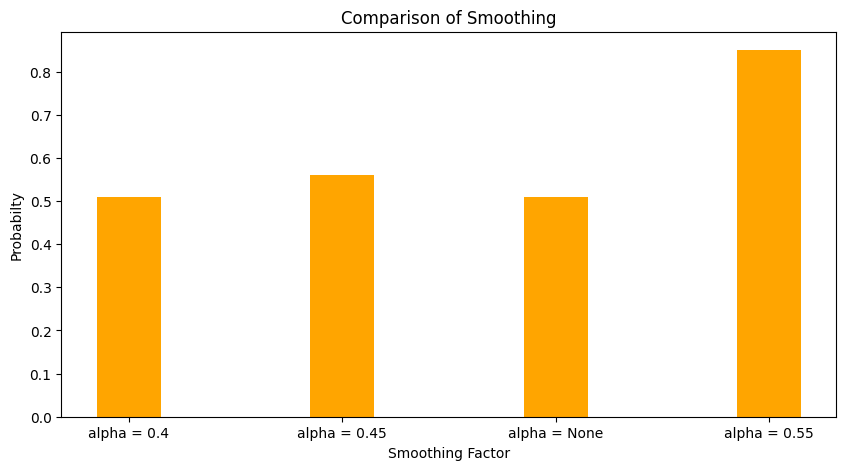

In [27]:
import numpy as np
import matplotlib.pyplot as plt



courses = [ "alpha = 0.4", "alpha = 0.45", "alpha = None", "alpha = 0.55"]
values = [0.51,0.56,0.51,0.85]

fig = plt.figure(figsize = (10, 5))

plt.bar(courses, values, color ='orange',width = 0.3)

plt.xlabel("Smoothing Factor")
plt.ylabel("Probabilty")
plt.title("Comparison of Smoothing")
plt.show()
